# Crash course on Time series : Evalauting Tesla stock price
Prof. Nik Bear Brown

## What is time series?

**Technical definition** - A time series is a set of data points collected over time, usually at regular intervals. In other words, it is a sequence of observations that are ordered chronologically and spaced at uniform time intervals. Time series data can be used to analyze trends, patterns, and relationships over time, and can provide insight into the behavior of complex systems.

Examples of time series data include daily stock prices, monthly sales figures, quarterly GDP growth rates, and annual weather patterns. Time series analysis techniques are commonly used in various fields such as economics, finance, engineering, social sciences, and environmental science.

**General concept** - Time series is like taking pictures of something over and over again, but each time you take a picture, you write down what time it is. So you end up with lots of pictures that show how that thing changes over time. Or, it's like watching a plant grow day by day or seeing how the weather changes every hour. By looking at these pictures, you can learn more about how things change over time!

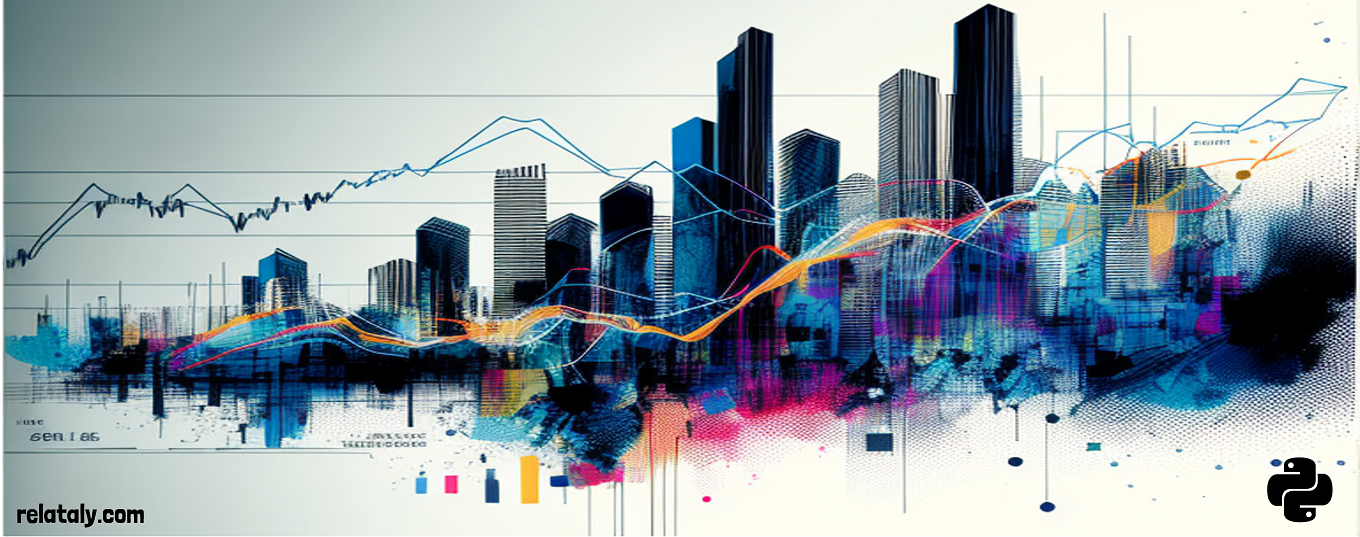



Stock prices are the prime example of such data. Predicting stock prices is a challenging task, but it can be done using a variety of time series forecasting techniques. In this article we will use fbprohet for forcasting TESLA's stock price.

# But, what is Prophet?
Prophet is a forecasting method developed by Facebook that is designed to work well with time series data. It models the trend, seasonality, and holiday effects in the data, and uses a Bayesian approach to estimate the uncertainty in the forecasts. Prophet is easy to use and can be very accurate, but it requires a large amount of data to work effectively.

There are some key concepts associated with time series forecasting-

**Trend**: A trend is a long-term pattern in the data that shows a general increase or decrease over time. It can be upward or downward and can be linear or nonlinear. Trends can be caused by various factors such as economic growth, demographic changes, or technological advancements.

**Cyclicity**: Cyclicity refers to the recurring patterns that occur in the data over time. These patterns are typically longer than seasonal patterns and can last several years or even decades. Cyclicity can be caused by various factors such as business cycles, political cycles, or natural cycles such as the El Nino weather phenomenon.

**Seasonality**: Seasonality refers to the recurring patterns that occur in the data over a fixed time period, such as a year, a month, a week, or a day. These patterns are typically shorter than cyclical patterns and can be caused by various factors such as weather patterns, holidays, or school schedules. Seasonality can also be affected by the type of industry or business that the data represents.

## Start with installing the dependencies - "prophet"

In [1]:
# pip install prophet

In [2]:
# from datetime import datetime 
# today=str(datetime.now().timestamp()).split('.')[0]

## Import the important libraries

In [3]:
import pandas as pd
from prophet import *
from datetime import*
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Load the dataset using yahoo finance

In [4]:

df = yf.Ticker('TSLA').history(period='max',interval='1d', actions = False)



We have extracted the daily data till date, and will resample it on a weekly/monthly basis

In [5]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500
...,...,...,...,...,...
2023-03-27 00:00:00-04:00,194.419998,197.389999,189.940002,191.809998,120851600
2023-03-28 00:00:00-04:00,192.000000,192.350006,185.429993,189.190002,98654600
2023-03-29 00:00:00-04:00,193.130005,195.289993,189.440002,193.880005,123660000


ADF Statistic: -0.934311
p-value: 0.776464
The time series is not stationary


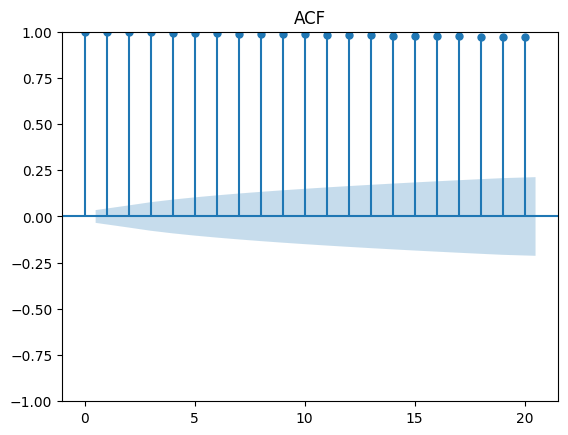

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


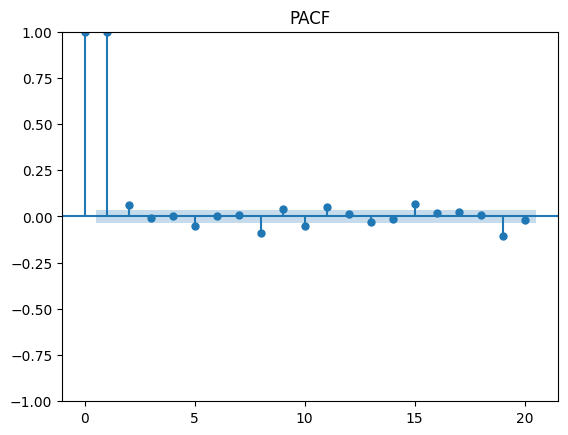

In [6]:
# Check if the time series is stationary
result = adfuller(df["Close"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
if result[1] > 0.05:
    print("The time series is not stationary")
else:
    print("The time series is stationary")

# Plot the autocorrelation and partial autocorrelation functions
plot_acf(df["Close"], lags=20)
plt.title("ACF")
plt.show()

plot_pacf(df["Close"], lags=20)
plt.title("PACF")
plt.show()

In [7]:
df = df.reset_index(0).reset_index(drop=True)

In [8]:
# Rename the columns to fit Prophet's requirements
df = df.rename(columns={'Date': 'ds', 'Close': 'y'})

In [9]:
df.tail()

,ds,Open,High,Low,y,Volume
3207,2023-03-27 00:00:00-04:00,194.419998,197.389999,189.940002,191.809998,120851600
3208,2023-03-28 00:00:00-04:00,192.000000,192.350006,185.429993,189.190002,98654600
3209,2023-03-29 00:00:00-04:00,193.130005,195.289993,189.440002,193.880005,123660000
3210,2023-03-30 00:00:00-04:00,195.580002,197.330002,194.419998,195.279999,110252200
3211,2023-03-31 00:00:00-04:00,197.529999,207.789993,197.229996,207.460007,169272334


The dataset contains

*   Date - stock price date
*   Open - market open value

*   High - high stock price
*   Low - low stock price

*   Close - market close value
*   Volume

As the date column comprises of timstamp, our job is to remove the timestamp as shown below

In [10]:
df['ds'] = pd.to_datetime(df['ds'])

In [11]:
df['ds'] = df['ds'].dt.tz_localize(None)

In [12]:
df

,ds,Open,High,Low,y,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,103003500
...,...,...,...,...,...,...
3207,2023-03-27,194.419998,197.389999,189.940002,191.809998,120851600
3208,2023-03-28,192.000000,192.350006,185.429993,189.190002,98654600
3209,2023-03-29,193.130005,195.289993,189.440002,193.880005,123660000
3210,2023-03-30,195.580002,197.330002,194.419998,195.279999,110252200


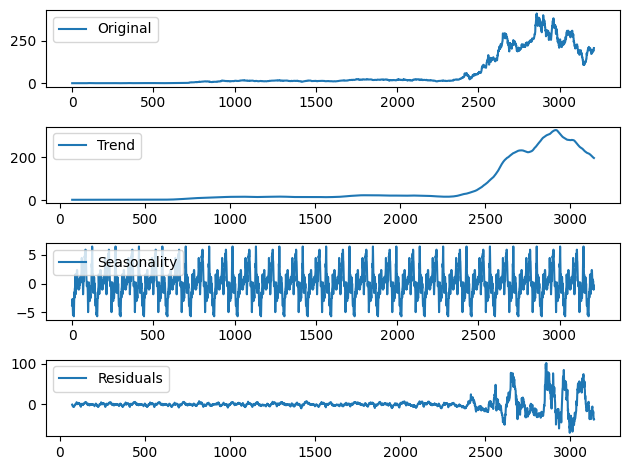

In [13]:
decomposition = seasonal_decompose(df['y'], model='additive', period=12*12)

# Plot the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df['y'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()

## Fitting the model

In [14]:
# Create a Prophet model
model = Prophet()

# Fit the model to the data
model.fit(df)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9ws8_ur1/lba4j40h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9ws8_ur1/61235lcr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40898', 'data', 'file=/tmp/tmp9ws8_ur1/lba4j40h.json', 'init=/tmp/tmp9ws8_ur1/61235lcr.json', 'output', 'file=/tmp/tmp9ws8_ur1/prophet_modelaxr90btv/prophet_model-20230401003414.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:34:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:34:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


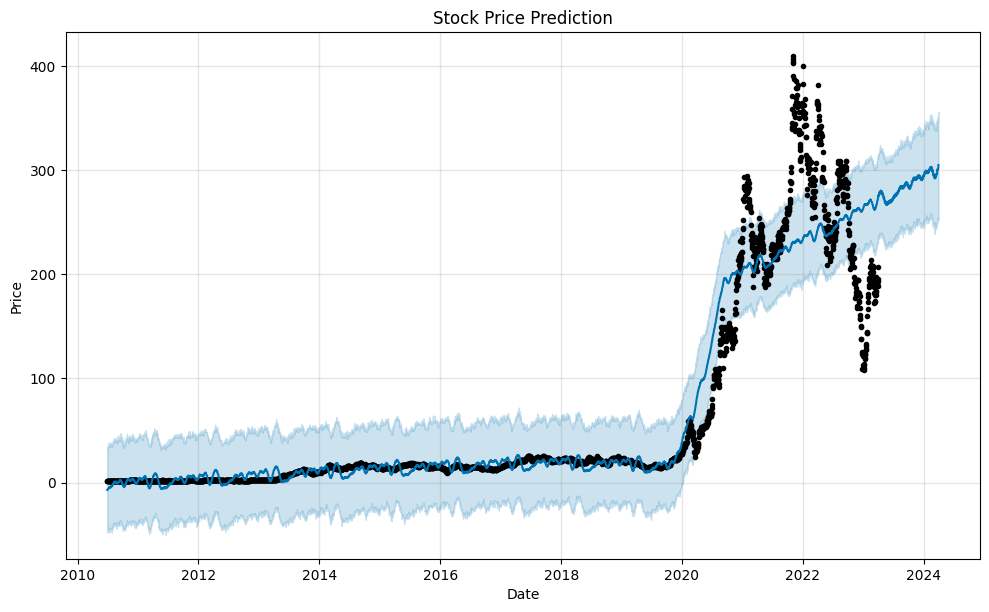

In [15]:
# Create a dataframe with future dates
future_dates = model.make_future_dataframe(periods=365)

# Make predictions for the future dates
predictions = model.predict(future_dates)

model.plot(predictions, xlabel='Date', ylabel='Price')
plt.title('Stock Price Prediction')
plt.show()


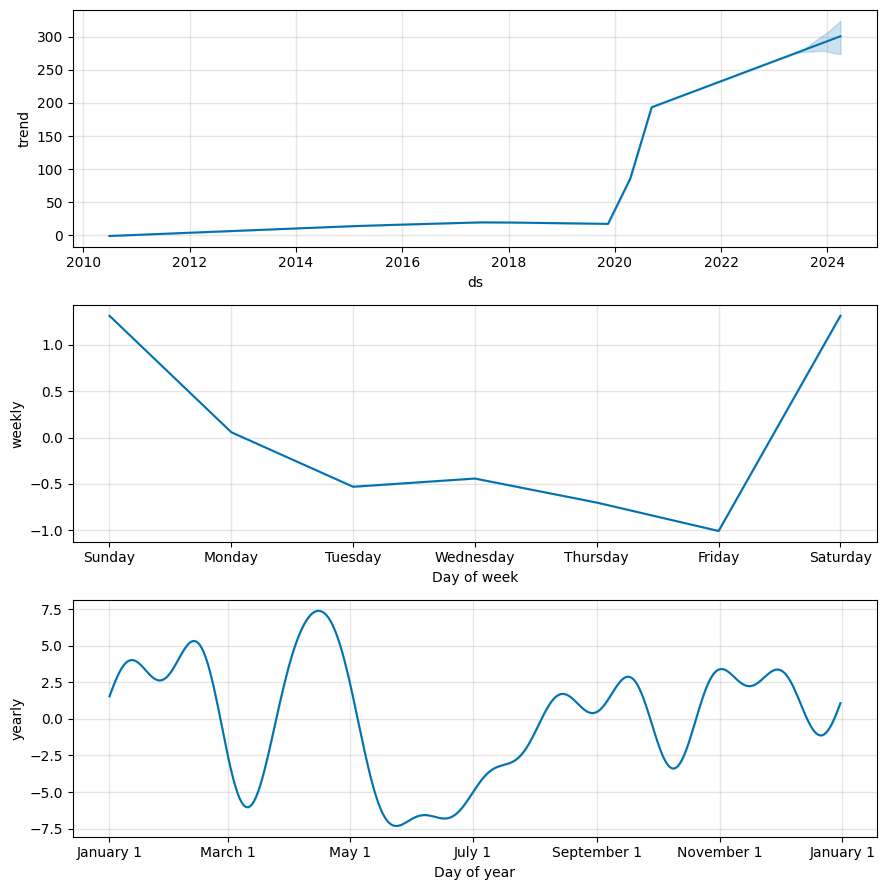

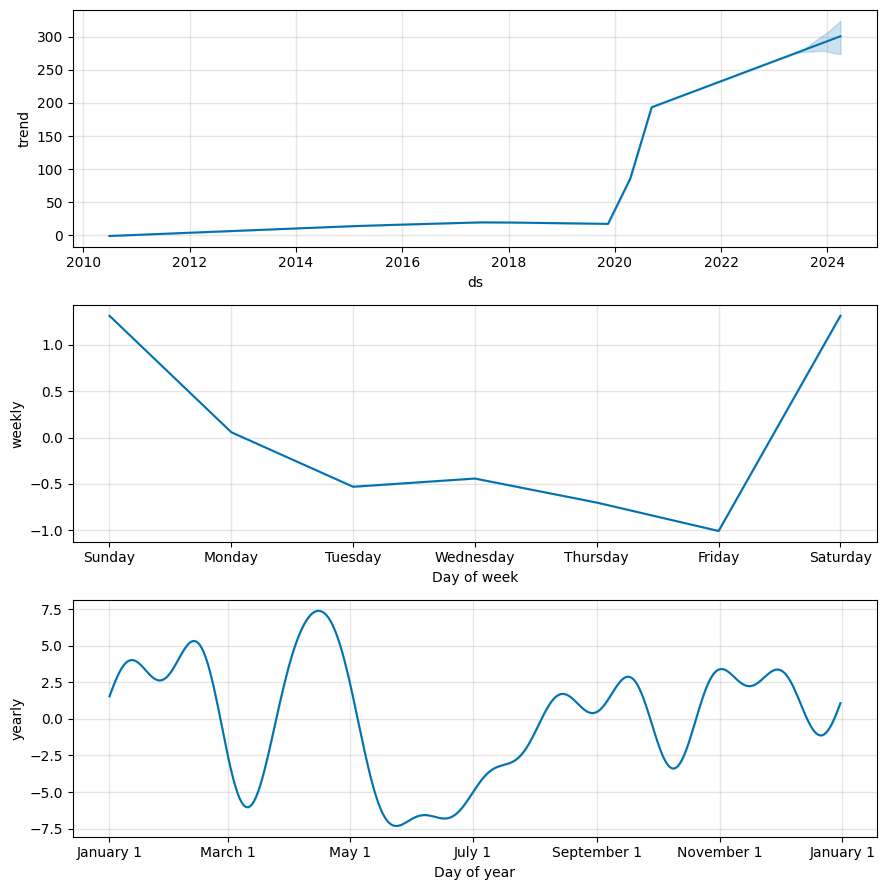

In [16]:
model.plot_components(predictions)


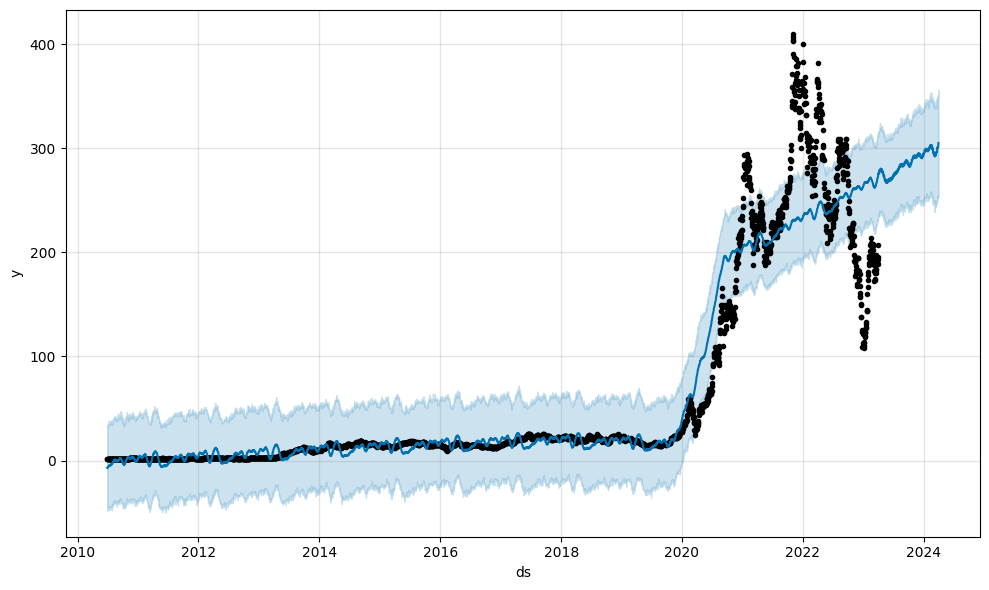

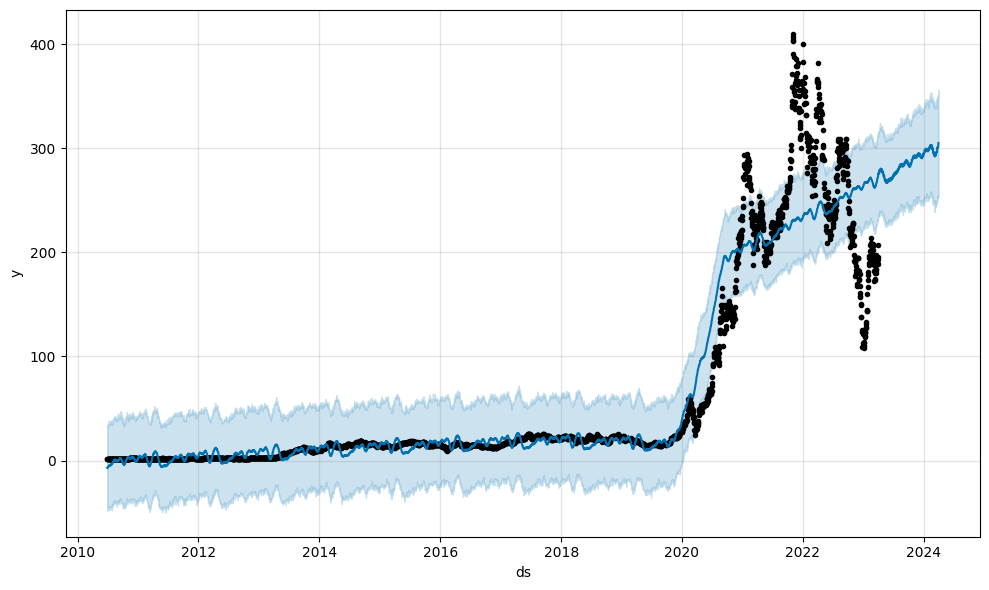

In [17]:
 model.plot(predictions, uncertainty=True)

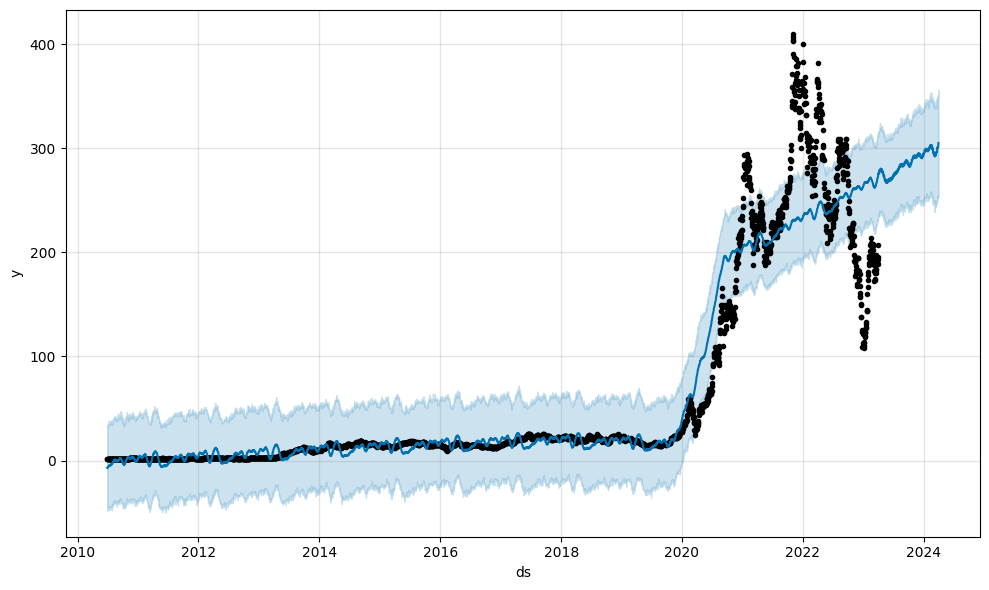

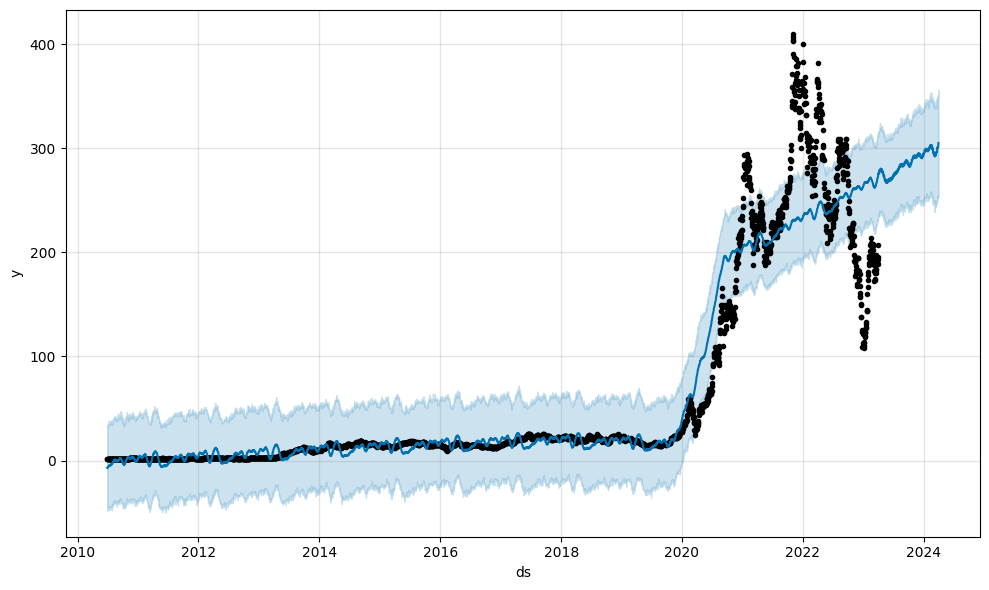

In [18]:
model.plot(predictions, uncertainty=True, plot_cap=True)

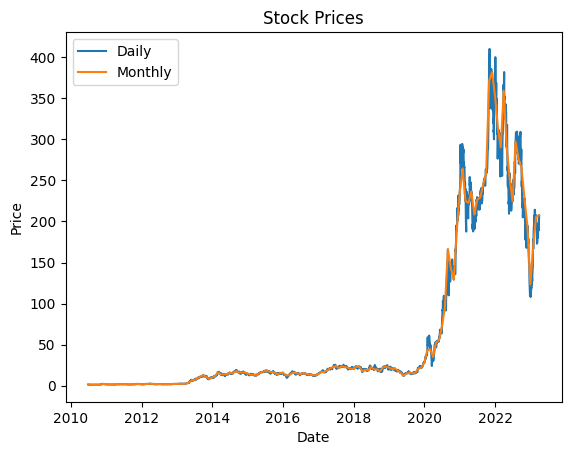

In [19]:
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# Resample to weekly frequency
df_weekly = df.resample('1M').last()

# Create line chart
plt.plot(df.index, df['y'], label='Daily')
plt.plot(df_weekly.index, df_weekly['y'], label='Monthly')

# Customize chart
plt.title('Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Display chart
plt.show()

# License
All code in this note is available as open source through the MIT license.

All text and images are free to use under the Creative Commons Attribution 3.0 license. https://creativecommons.org/licenses/by/3.0/us/

These licenses let others distribute, remix, tweak, and build upon the work, even commercially, as long as they give credit for the original creation.

Copyright 2021 AI Skunks

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.